# Проект по А/B-тестированию
# Постановка задачи
Задача — провести оценку результатов A/B-теста. В распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

Оценить корректность проведения теста.

Проанализировать результаты теста.

Чтобы оценить корректность проведения теста нужно проверить:

пересечение тестовой аудитории с конкурирующим тестом;

совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

Техническое задание:

Название теста: recommender_system_test;

Группы: А (контрольная), B (новая платёжная воронка);

Дата запуска: 2020-12-07;

Дата остановки набора новых пользователей: 2020-12-21;

Дата остановки: 2021-01-04;

Аудитория: 15% новых пользователей из региона EU;

Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;

Ожидаемое количество участников теста: 6000.

Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:

конверсии в просмотр карточек товаров — событие product_page
просмотры корзины — product_cart
покупки — purchase.

Данные
ab_project_marketing_events.csv

* final_ab_new_users.csv
* final_ab_events.csv
* final_ab_participants.csv

* /datasets/ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год;
Структура файла:
  
- name — название маркетингового события;
- regions — регионы, в которых будет проводиться рекламная кампания;
- start_dt — дата начала кампании;
- finish_dt — дата завершения кампании.

* /datasets/final_ab_new_users.csv — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;
Структура файла:

- user_id — идентификатор пользователя;
- first_date — дата регистрации;
- region — регион пользователя;
- device — устройство, с которого происходила регистрация.

* /datasets/final_ab_events.csv — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;
Структура файла:
- user_id — идентификатор пользователя;
- event_dt — дата и время события;
- event_name — тип события;
- details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

* /datasets/final_ab_participants.csv — таблица участников тестов.
Структура файла:
- user_id — идентификатор пользователя;
- ab_test — название теста;
- group — группа пользователя.


### Переработка данных

In [40]:
import pandas as pd
import numpy as np
import math as math
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from scipy import stats as st

In [41]:
# загрузим данные
marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')

In [42]:
print(marketing_events.info())
print(' ')
print(marketing_events.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None
 
0


In [43]:
print(events.info())
print(' ')
print(events.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None
 
0


In [44]:
# отобразим количество пропусков
events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

In [45]:
# выведем долю пропусков в столбце 'details' от всего датасета
events['details'].isna().sum() / len(events)

0.8575117472184812

In [46]:
# посмотрим значения в столбце 'details'
events['details'].value_counts()

4.99      46362
9.99       9530
99.99      5631
499.99     1217
Name: details, dtype: int64

In [47]:
# посмотрим значения в столбце событий 
events['event_name'].value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

In [48]:
print(new_users.info())
print(' ')
print(new_users.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None
 
0


In [49]:
display(participants.head())
print(' ')
display(participants.info())

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

In [50]:
# переведем все столбцы с датами в датасетах во временной формат
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
events['event_dt'] = pd.to_datetime(events['event_dt'])

# Вывод
Данные успешно загружены и в целом в порядке. Большое количество пропусков в файле событий в столбце details скорее всего связано с тем, что в этом столбце указана выручка с события, а если пользователей не совершил покупку, то указывается пропущенное значение.

### Оценка корректности проведения теста

In [51]:
# проверим время начала и конца событий совершенных пользователями
print(events['event_dt'].min())
print(events['event_dt'].max())

2020-12-07 00:00:33
2020-12-30 23:36:33


In [52]:
# проверим время начала и конца регистраций новых пользователей
print(new_users['first_date'].min())
print(new_users['first_date'].max())

2020-12-07 00:00:00
2020-12-23 00:00:00


In [53]:
len(new_users['first_date'])

61733

In [54]:
test_region = new_users.merge(participants, how = 'left', on = 'user_id') 
test_region = test_region.query('ab_test == "recommender_system_test"and region == "EU"')
test_region.shape[0]

6351

In [55]:
# проверим время начала и конца событий совершенных пользователями
print(test_region['first_date'].min())
print(test_region['first_date'].max())

2020-12-07 00:00:00
2020-12-21 00:00:00


In [56]:
region_date = new_users.query('region == "EU" and "2020-12-07" <= first_date <= "2020-12-21"')
region_date.shape[0]

42340

In [57]:
test_region.shape[0]/ region_date.shape[0]

0.15

15 % новых пользователей из региона EU - соответсвует ТЗ.

In [58]:
# проверим попали ли маркетинговые события на время проведения теста
marketing_events[(marketing_events['start_dt'] >= '2020-12-07') & (marketing_events['start_dt'] <= '2020-12-30')]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Пользователей участнико в АБ теста набирали c 7 no 21 декабря, за это время никакиx мероприятий не происxодило. Aб-тест неудачно выпал на новогодние праздники. Taк как исследование проводилось в европейском регионе, принимать во внимание стоит одно событие - Christmas&New Year Promo, которое npoxодило с 25 декабря по 3 января. Будем иметь ввиду, что данные за этот период скорее всeгo искажены, так как имел место быть сезонный фактор.

In [59]:
# выведем количество пользователей в тестах
participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

Ожидаемое количество участников теста: 6000. У нас количество участиков побольше.Норма

In [60]:
participants.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test                 group         
interface_eu_test       A         5831
                        B         5736
recommender_system_test A         3824
                        B         2877

Видно, что у нас есть также другой тест, который проводился параллельно с нашим - interface_eu_test. 

In [61]:
tests = participants.groupby('user_id').agg({'ab_test': 'nunique'}).sort_values(by = 'ab_test', ascending = False).reset_index()
# добавили к юзерам количество тестов, в которое они входят (1 или 2)
two_test = tests.loc[tests['ab_test'] == 2]
users_two_test = two_test['user_id']
# выделил отдельно список пользователей, которые входят в 2 теста одновременно
len(two_test)

1602

1602 пользователя входят в оба теста

In [62]:
users_two_test = participants.query('user_id in @users_two_test').reset_index(drop=True)
# обрезали данные по списке
users_two_test.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})
# вывели в какие группы входят наши пользователи

user_id
ab_test                 group         
interface_eu_test       A          819
                        B          783
recommender_system_test A          921
                        B          681

In [63]:
participants = participants.query('ab_test == "recommender_system_test"')
participants.groupby('group').agg({'user_id': 'nunique'})

,user_id
group,
A,3824
B,2877


Видно, что 947 пользователей больше в группе А.

In [64]:
group_a = list(participants.query('group == "A"') ['user_id'].unique()) 
group_b = list(participants.query('group == "B"') ['user_id'].unique()) 
group_a_b = []

for i in group_b:
    if i in group_a:
        group_a_b.append(1)

len(group_a_b)

0

Пересечений внутри теста recommender_system_test между А и Б группами нет.

In [65]:
events = events.merge(participants, on='user_id')\
.merge(new_users, on='user_id', how='left')

In [66]:
events['lifetime'] = (events['event_dt'] - events['first_date']).dt.days
display(events['lifetime'].value_counts())
display(events['user_id'].nunique())

0     8131
1     3754
2     2578
3     1805
4     1494
5     1208
6     1070
7      986
8      762
9      606
10     517
12     347
11     347
13     251
14     214
15     171
16      94
17      86
18      80
20      69
19      60
21      33
22      31
23       4
Name: lifetime, dtype: int64

3675

In [67]:
events = events.query('lifetime <= 14')
display(events['lifetime'].value_counts())
display(events['user_id'].nunique())

0     8131
1     3754
2     2578
3     1805
4     1494
5     1208
6     1070
7      986
8      762
9      606
10     517
12     347
11     347
13     251
14     214
Name: lifetime, dtype: int64

3675

In [68]:
# проверим время начала и конца событий совершенных пользователями после среза по лайфтайму
print(events['event_dt'].min())
print(events['event_dt'].max())

2020-12-07 00:05:57
2020-12-29 23:38:29


In [69]:
# проверим время начала и конца регистраций новых пользователей
print(events['first_date'].min())
print(events['first_date'].max())

2020-12-07 00:00:00
2020-12-21 00:00:00


# Вывод:
В ходе изучения корректности теста recommender_system_test в соответствии с ТЗ мы обнаружили следующее:

* Тест был остановлен раньше - 2020-12-29, а по ТЗ должен был быть остановлен 2021-01-04.
* Набор новых пользователей был остановлен  2020-12-21. Соответсвует ТЗ.
* Время теста совпадает с проведением маркетинговым мероприятием, что является нарушением проведения теста, так как искальжает обычное поведение пользователей. Окончание теста было 2020-12-29, а старт маркетинговой акции был 2020-12-25. Исходя из этого 4 дней теста не является репрезентативными.
* Новых пользователей из EU набрали 15% из требуемых 15% по ТЗ.
* В тест попали пользователи из других стран, а не только из EU. А в оба теста попали 1602 пользователей.
* Из требуемых 6000 пользователей в тесте по ТЗ у нас их больше видимо из за набора после окончания теста.
* Количества пользователей в группах теста распределены не равномерно.Такая неравномерность приведет к искальжению результатов в сторону группы А.

### Исследовательский анализ данных:

# Количество событий на пользователя одинаково распределены в выборках?

In [70]:
# проверим сколько уникальных тестов было проведено
participants['ab_test'].unique()

array(['recommender_system_test'], dtype=object)

In [71]:
# создадим датасет с тестом рекомендательной системы (тех задание)
recommender_system_test = participants[participants['ab_test'] == 'recommender_system_test'].copy()

In [72]:
# разобьем тест на группы
group_a = recommender_system_test[recommender_system_test['group'] == 'A'].drop('ab_test', axis=1)
group_b = recommender_system_test[recommender_system_test['group'] == 'B'].drop('ab_test', axis=1)

In [73]:
# посчитаем количество событий для каждого ползователя
user_events = events.groupby('user_id').agg({'event_name':'count'})

In [74]:
group_a_user_events = user_events.merge(group_a, how='inner', on='user_id')
group_b_user_events = user_events.merge(group_b, how='inner', on='user_id')

In [75]:
group_user_events = pd.concat([group_a_user_events, group_b_user_events])


In [76]:
group_user_events.head()

,user_id,event_name,group
0,0010A1C096941592,12,A
1,00341D8401F0F665,2,A
2,003DF44D7589BBD4,15,A
3,00505E15A9D81546,5,A
4,006E3E4E232CE760,6,A


In [79]:
px.histogram(group_user_events, x='event_name', title='Распределение событий по пользователям' ,color='group')

Мы видим, что количество событий на одного пользователя распределились неранвомерно в обеих группах. Однако, в группе "А" характер неравномерности выражен более явно - имеют место явные провалы и высокие пики.

In [80]:
print('Среднее количество событий в группе А {}'.format(group_a_user_events['event_name'].mean().round(2)))
print('Среднее количество событий в группе B {}'.format(group_b_user_events['event_name'].mean().round(2)))

AttributeError: 'float' object has no attribute 'round'

По группе А среднне количество событий на одного пользователя выше, чем по группе В.

# Как число событий распределено по дням?

In [81]:
# посчитаем количество событий по дням
events['date'] = events['event_dt'].dt.date
user_events = events.groupby('date').agg({'event_name':'count'}).reset_index()

In [82]:
events['date'] = events['event_dt'].dt.date

In [83]:
user_events_a = events[events['group'] == 'A'].groupby('date').agg({'event_name':'count'}).reset_index()
user_events_b = events[events['group'] == 'B'].groupby('date').agg({'event_name':'count'}).reset_index()

In [84]:
group_user_ev = pd.concat([user_events_a , user_events_b])


In [85]:
px.bar(group_user_ev, x='date', y='event_name', title='Распределение событий по дням', text='event_name')

Видно, что пик активностей 21 декабря, в последний день набора пользователей. И резкой скачок активности 14 декабря.
Тест запускался 7 декабря. Новых пользователей остановили набирать 21 декабря согласно ТЗ. 
Сам тест завершился 4 января. Однако у нас нет данных с 30-го декабря.

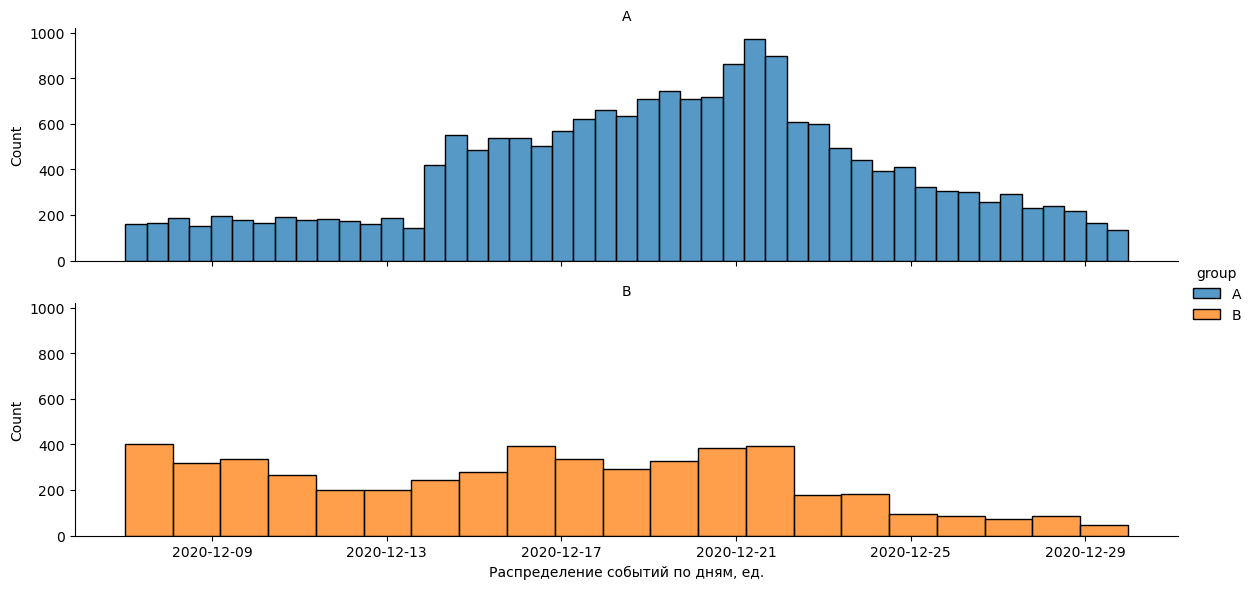

In [86]:
g = sns.FacetGrid(events, row='group', hue='group',
                  height=3, aspect=4)
g.map(sns.histplot, 'event_dt')
g.set_xlabels('Распределение событий по дням, ед.')
g.set_titles(row_template='{row_name}')
g.add_legend();

# Как меняется конверсия в воронке в выборках на разных этапах?

In [87]:
# оставим пользователей из региона EU
group_a_total = group_a.merge(new_users, how = 'inner', on='user_id')
group_b_total = group_b.merge(new_users, how = 'inner', on='user_id')

In [88]:
group_a_EU = group_a_total[group_a_total['region'] == 'EU'].copy()
group_b_EU = group_b_total[group_b_total['region'] == 'EU'].copy()

In [89]:
group_a_union = group_a_EU.merge(events, how = 'left', on = 'user_id')
group_b_union = group_b_EU.merge(events, how = 'left', on = 'user_id')

In [90]:
group_a_grouped = (group_a_union
                   .groupby('event_name')
                   .agg({'user_id':'nunique'})
                   .sort_values(by = 'user_id', ascending=False)
                   .reset_index())
group_b_grouped = (group_b_union
                   .groupby('event_name')
                   .agg({'user_id':'nunique'})
                   .sort_values(by = 'user_id', ascending=False)
                   .reset_index())

In [91]:
a1=group_a_grouped.reindex([0,1,3,2])
b2=group_b_grouped.reindex([0,1,3,2])

In [92]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Group A',
    y = a1['event_name'],
    x = a1['user_id'],
    textinfo = "value+percent initial"
))

fig.add_trace(go.Funnel(
    name = 'Group B',
    y = b2['event_name'],
    x = b2['user_id'],
    textinfo = "value+percent initial"
))

fig.update_layout(title_text='Конверсия пользователей AB')
fig.show()

Наблюдается большое различие между группами A и B. Разница в 2 -3 раза.
Мы видим, что конверсия в шаг начиная с регистрации равномерно уменьшалась, а на шаге покупка демонстрирует увеличение числа событий. Это может быть связано либо с ошибками в данных, либо с внешним пересечением событий по различным мероприятийм и тестам, которые накладывались друг на друга, либо, что наиболее вероятно, с возможностью совершения покупки, минуя корзину.

### Проведение AB  теста

In [93]:
# оставляем только данные теста recommender_system_test
participants = participants[participants.ab_test == 'recommender_system_test']

# события пользователей, участвующих в тесте
events_participants = events.merge(participants, on=('user_id','group','ab_test'), how='inner')

# группа А
group_A_events_participants = events_participants[events_participants.group == 'A']

# группа В
group_B_events_participants = events_participants[events_participants.group == 'B']

Для проверки статистически значимой разницы между группами в событиях воронки мы будем использовать двухстороний Z-тест с поправкой Бонферрони.

Гипотезы для проведения Z-теста следующие:

* H0 Нулевая гипотеза - доли уникальных посетителей на этапе воронки одинаковы.
* H1 Альтернативная гипотеза - между долями уникальных посетителей на этапе воронки есть значимая разница.

In [94]:
def get_conversion(df:pd.DataFrame):

    result_df = (
        df.groupby('event_name')
        .agg({'user_id' : 'nunique'})
        .rename(columns={'user_id' : 'num_users'})
        .sort_values(by='num_users', ascending=False)
        
    )
    
    # добавляем столбец с конверсией
    result_df['conversion'] = result_df['num_users'] / result_df.loc['login', 'num_users']
    
    return result_df.round(2)


def check_fractions(
    name_first_group,
    name_second_group,
    trial_first_group,
    trial_second_group,
    success_first_group,
    success_second_group,
    alpha=0.05):
   
    # успехи
    successes = np.array([success_first_group, success_second_group])
    # попытки
    trials = np.array([trial_first_group, trial_second_group])
    
    alpha = alpha
    
    # пропорция успехов в первой группе
    p1 = successes[0] / trials[0]
    
    # пропорция успехов во второй группе
    p2 = successes[1] / trials[1]
    
    print(successes[0], successes[1], trials[0], trials[1])
    
    # разница пропорций в датасетах
    difference = p1 - p2
    
    # пропорция успехов в комбинированном датасете
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    
    # считаем статистику в стандартных отклонениях стандартного нормального распределения
    z_value = difference / math.sqrt(
        p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1]))
    
    # задаём стандартное нормальное распределение со средним 0 и стандартным отклонением 1
    distribution = st.norm(0, 1)
    
    print('z_value:', z_value)
    # тест двусторонний
    p_value = (1 - distribution.cdf(abs(z_value))) * 2
    print('p_value:', p_value)
    
    if p_value < alpha:
        print(
            f'Отвергаем нулевую гипотезу: между долями групп {name_first_group} и {name_second_group} есть значимая разница'
        )
    else:
        print(
            f'Не отвергаем нулевую гипотезу: нет оснований считать доли групп {name_first_group} и {name_second_group} разными'
        )
        
        
def display_check_fractions(
    name_first_group,
    name_second_group,
    df1,
    df2,
    alpha=0.05
):
     
    # максимальный индекс
    index = max(df1.index.tolist())
    
    # имя шага из столбца event name
    names_step = df1['event_name'].tolist()
    
    # в цикле вызываем функцию check_fractions
    for i, step in zip(range(index + 1), names_step):
        print(f'Шаг: {step}')
        check_fractions(
            name_first_group,
            name_second_group,
            df1.loc[i, 'total'],
            df2.loc[i, 'total'],
            df1.loc[i, 'num_users'],
            df2.loc[i, 'num_users'],
            alpha=alpha
        )
        print()

In [95]:
events_participants['event_name'].unique()

array(['purchase', 'product_cart', 'login', 'product_page'], dtype=object)

In [96]:
# конверсия в группе А
group_A_conversion_df = get_conversion(group_A_events_participants)

# конверсия в группе В
group_B_conversion_df = get_conversion(group_B_events_participants)

display(
    [group_A_conversion_df, group_B_conversion_df], 
    ['group_A_conversion_df', 'group_B_conversion_df']
)

[              num_users  conversion
 event_name                         
 login              2747        1.00
 product_page       1780        0.65
 purchase            872        0.32
 product_cart        824        0.30,
               num_users  conversion
 event_name                         
 login               927        1.00
 product_page        523        0.56
 purchase            256        0.28
 product_cart        255        0.28]

['group_A_conversion_df', 'group_B_conversion_df']

- Некоторые пользователи переходят к покупке товара минуя страницу товара и корзину с товарами. Из-за этого число покупок в обоих группах больше, чем переходов в корзину с товарами. Это вполне нормально
- Конверсия в группе А больше чем в группе В: 31.7% против 27.6%
- Оплата должна быть заключительным шагом воронки. Поменяем порядок в воронке и визуализируем.

In [97]:
# новый порядок индексации
new_index = ['login', 'product_page', 'product_cart', 'purchase']

group_A_conversion_df = group_A_conversion_df.reindex(new_index)

group_B_conversion_df = group_B_conversion_df.reindex(new_index)

display(
    [group_A_conversion_df, group_B_conversion_df], 
    ['group_A_conversion_df', 'group_B_conversion_df']
)

[              num_users  conversion
 event_name                         
 login              2747        1.00
 product_page       1780        0.65
 product_cart        824        0.30
 purchase            872        0.32,
               num_users  conversion
 event_name                         
 login               927        1.00
 product_page        523        0.56
 product_cart        255        0.28
 purchase            256        0.28]

['group_A_conversion_df', 'group_B_conversion_df']

In [98]:
group_A_conversion_df['total'] = group_A_conversion_df.loc['login', 'num_users']
group_B_conversion_df['total'] = group_B_conversion_df.loc['login', 'num_users']

# строки с индексом (событием) login нам не нужны
group_A_conversion_df = group_A_conversion_df.loc['product_page':,]
group_B_conversion_df = group_B_conversion_df.loc['product_page':,]

# для функции нужны целочисленные индексы, поэтому резетим индексы
group_A_conversion_df = group_A_conversion_df.reset_index()
group_B_conversion_df = group_B_conversion_df.reset_index()

display(
    [group_A_conversion_df, group_B_conversion_df], 
    ['group_A_conversion_df', 'group_B_conversion_df']
)

[     event_name  num_users  conversion  total
 0  product_page       1780        0.65   2747
 1  product_cart        824        0.30   2747
 2      purchase        872        0.32   2747,
      event_name  num_users  conversion  total
 0  product_page        523        0.56    927
 1  product_cart        255        0.28    927
 2      purchase        256        0.28    927]

['group_A_conversion_df', 'group_B_conversion_df']

In [99]:
alpha = 0.05

# Всего 3 сравнения
bonferroni_alpha = 0.05 / 3

display_check_fractions('A', 'B', group_A_conversion_df, group_B_conversion_df, alpha=bonferroni_alpha)


Шаг: product_page
1780 523 2747 927
z_value: 4.561276066964096
p_value: 5.084368080776613e-06
Отвергаем нулевую гипотезу: между долями групп A и B есть значимая разница

Шаг: product_cart
824 255 2747 927
z_value: 1.4383239332989086
p_value: 0.15034216422194624
Не отвергаем нулевую гипотезу: нет оснований считать доли групп A и B разными

Шаг: purchase
872 256 2747 927
z_value: 2.355965515484171
p_value: 0.018474632659979617
Не отвергаем нулевую гипотезу: нет оснований считать доли групп A и B разными



Вывод:

* на шаге product_page (переход на страницу товара) между конверсиями групп А и В есть значимая разница
* на шаге product_cart (переход в корзину) между конверсиями групп А и В нет значимой разницы
* на шаге purchase (оплата товара) между конверсиями групп А и В нет значимой разницы

### Вывод:

В ходе анализа данных были исправлены типы данных, дубли необнаружены.Нет полных данных

Были построены воронки конверсии. Воронка показала то, что пользователь может перейти на страницу оплаты минуя остальные страницы (авторизация, страница продукта, корзина). 
Конверсии на шаге оплаты товара в группе А составляет 31.7%, в группе В - 27.6%

A/B тест пересекается сразу с двумя маркетинговыми активностями.

Количество пользователей распределено неравномерно.При идеальном делении 50\50.Количество пользователей в группе А на 25% больше чем в группе В. Это очень большая разница. 

В процессе анализа были установлены факты, которые отрицательно повлияли на корректность А-В-теста, а именно:
во время проведения A-B-теста проводились маркетинговая акция Christmas&New Year Promo с 2020-12-25 по 2021-01-03.

У нас нет данных с 29-го декабря и по 4 января.
 

Проведя А/В тест с применением Z критерия, было выявлено, что статистически значимой разницы между группами А/В есть на  этапе  страницы продукта, на всех остальных этапах нет.


Ввиду выше сказанного, данный тест считаю не ооочень не успешным.

Нельзя принимать результаты данного тестирования. Рекомендую заново провести AB-тестирование, соблюдая все правила корректного проведения.

# Рекомендации:

необходимо проанализировать алгоритм новой системы рекомендации и внести изменения.

провести следущий тест в более подходящее время равноудаленное от маркетинговых событий и больших праздников.